<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/qian/blender_passes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Training Data using Blender
#### Qian Huang
#### Feb 24

why blender?

-- scene
* open source & python-programmable
* can easily create 3d scene
* with transformations
* in-built textures

-- forward model:
* camera model
* high bit depth raw/rgb output, gt depth & flow


√functions to be tested:
* add shapes: location, posture, types
* add textures
* add transformations

√output to be tested:
* optical flow
* depth

## test functionality of blender output

In [ ]:
! unzip -q drive/MyDrive/blender_archive.zip

In [ ]:
import cv2
img = cv2.imread('Depth/Image0001.exr',cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) 
img.shape

(64, 64, 3)

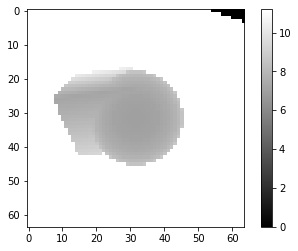

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
img[img > 10000] = 0
plt.imshow(img[:, :, 0], cmap='gray')
plt.colorbar()
plt.show()

Three channels share same value.

optical flow:

http://www.tobias-weis.de/groundtruth-data-for-computer-vision-with-blender/

https://blender.stackexchange.com/questions/66145/track-a-pixel-between-frames-using-speed-vector-outputs/66157

In [ ]:
vector = cv2.imread('Vector/Image0002.exr',cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) 

In [ ]:
vector[:, :, 1] = -vector[:, :, 1]
vector[:, :, [0, 1, 2]] = vector[:, :, [2, 1, 0]] ## READ IN AS BGR

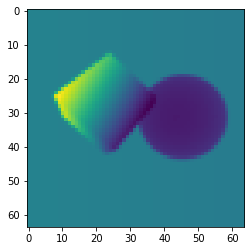

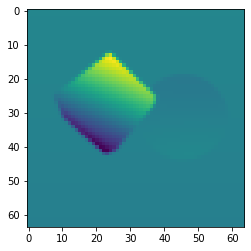

In [ ]:
plt.imshow(vector[:, :, 0]/vector.max())
plt.show()
plt.imshow(vector[:, :, 1]/vector.max())
plt.show()

In [ ]:
img1 = cv2.imread('Image/Image0001.png',cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)[:, :, ::-1]/(2**16-1)
img2 = cv2.imread('Image/Image0002.png',cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)[:, :, ::-1]/(2**16-1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
class WarpLayer(nn.Module):
    
    def __init__(self):
        super(WarpLayer, self).__init__()
        
    def warp(self, x, flo):
        """
        warp an image/tensor (im2) back to im1, according to the optical flow
        x: [B, C, H, W] (im2)
        flo: [B, 2, H, W] flow
        """
        B, C, H, W = x.size()
        # mesh grid 
        xx = torch.arange(0, W).view(1,-1).repeat(H,1)
        yy = torch.arange(0, H).view(-1,1).repeat(1,W)
        xx = xx.view(1,1,H,W).repeat(B,1,1,1)
        yy = yy.view(1,1,H,W).repeat(B,1,1,1)
        grid = torch.cat((xx,yy),1).float()

        if x.is_cuda:
            grid = grid.cuda()
        vgrid = Variable(grid) + flo

        # scale grid to [-1,1] 
        vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
        vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

        vgrid = vgrid.permute(0,2,3,1)        
        output = nn.functional.grid_sample(x, vgrid)
        mask = torch.autograd.Variable(torch.ones(x.size()))
        mask = nn.functional.grid_sample(mask, vgrid)

        # if W==128:
            # np.save('mask.npy', mask.cpu().data.numpy())
            # np.save('warp.npy', output.cpu().data.numpy())
        
        mask[mask<0.9999] = 0
        mask[mask>0] = 1
        
        return output*mask
    
    def forward(self, x, flow):        
        x = self.warp(x, flow) 
        return x

In [ ]:
model = WarpLayer()

In [ ]:
img1_tensor = torch.from_numpy(img1.transpose(2, 0, 1)).unsqueeze(0).float()
img2_tensor = torch.from_numpy(img2.transpose(2, 0, 1)).unsqueeze(0).float()
flow_tensor = torch.from_numpy(vector[:, :, :2].transpose(2, 0, 1)).unsqueeze(0).float()
output = model(img1_tensor, flow_tensor)
img1_warped = output[0].numpy().transpose(1, 2, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


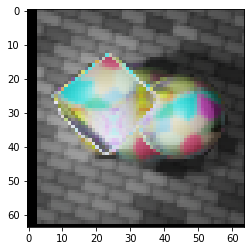

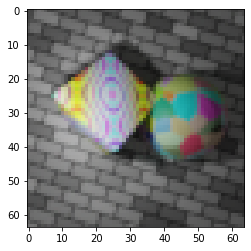

In [ ]:
plt.imshow(img1_warped)
plt.show()
plt.imshow(img2)
plt.show()

## Changes mentioned in Wulff's MPI-Sintel workshop paper:

* ~~weighted combine flow is meaningless -> turn off anti-aliasing (P172)~~
    [reddit](https://www.reddit.com/r/blender/comments/bba64l/how_to_turn_off_anti_aliasing_in_cycles_render/ekhgsub/?context=8&depth=9)
    [stackexchange](https://blender.stackexchange.com/questions/3299/how-to-save-an-image-without-antialiasing-in-cycles)

    ~~*cycles->film->pixel filter->width->0.01px*~~
* motion blur

    *disable motion blur [link](https://blender.stackexchange.com/questions/66057/avoid-motion-blur-in-rendering)*
* Displacement map (P173) 

    *no effect if no displacement map is applied*
* Data Halo (P173)

    *no effect if no displacement map is applied*
* Blender optical flow is mistakenly interpolated inside a triangle (P174)

    *not a significant issue, as merge network is supposed to tolerate misalignment*.


Other problems:
* raw output? 

    *OpenEXR is not effected by render->color management. PNG is.*

* render engine sample noise

    *render properties -> sampling -> render sample -> 4096*

* speed up render

    *render properties -> light path -> max light bounce -> 1*

## Generation process:
#### **updated Mar 9 with anti-aliasing**
should consider HDR setting: well-lit area and poor-lit area are co-existing.

should consider the local scene: 
* lighting condition stays fairly consistent
* motion

Blender script:
* initialize scene settings
    * render engine and #samples
    * resolution: 64px
    * number of frames: 240
* clear current collection
* create camera, light
* create background cube w/ random texture
* create meshes w/ random:
    * type (cube/sphere/cone/...)
    * size
    * texture
* collect objects and generate key_frames
    * location
    * transformation
* output
    * image (raw)
    * optical flow
    * depth







In [1]:
! unzip -q drive/MyDrive/blender_antialiasing.zip

In [2]:
def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### inspect openexr image

#### image visual & stat

In [17]:
img = cv2.imread("Image/Image0100.exr",cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)[:, :, ::-1]
print_stat(img)
print("Dynamic range is {:.1f} bits".format(np.log2(img.max()/img.min())))

Array shape:  (64, 64, 3) dtype: float32
Array stat: max: 4.6015625, min: 0.0066375732421875, mean: 0.7595565319061279, std: 0.8263634443283081
Dynamic range is 9.4 bits


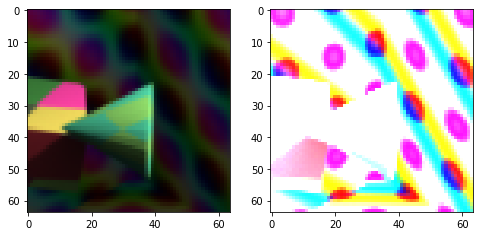

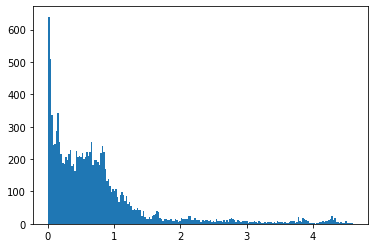

In [18]:
fig, ax = plt.subplots(1,2, figsize = (8, 8))
ax[0].imshow(img/img.max())
ax[1].imshow(np.clip(img * 5, 0, 1))
plt.show()
# fig, ax = plt.subplots(1,2)
# ax[0].hist(img.flatten(), bins=100)
# ax[1].hist(img.flatten(), bins=100, range=(0, 0.4))
# fig.tight_layout()
plt.hist(img.flatten(), bins=200)
plt.show()

In [19]:
# fig, ax = plt.subplots(1, 4, figsize = (16, 8))
# ax[0].imshow((img < 0.025).astype(np.float))
# ax[1].imshow((img > 0.025).astype(np.float) * (img < 0.25).astype(np.float))
# ax[2].imshow((img > 0.25).astype(np.float) * (img < 1).astype(np.float))
# ax[3].imshow((img > 1).astype(np.float))
# plt.show()

#### details

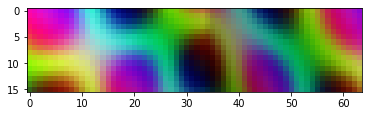

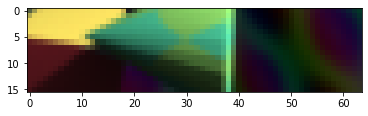

In [20]:
plt.imshow(img[:16]/img[:16].max())
plt.show()
plt.imshow(img[-32:-16]/img[-32:-16].max())
plt.show()

### forward process:
LDR forward model:
$y = \mathcal{N}(x, \sigma^2 = \sigma_r^2 + \sigma_s x)$, where  
- $y$: measurement
- $x$: groundtruth
- $\sigma_r$: read noise coefficient
- $\sigma_s$: shot noise coefficient

For our camera, by experiment, $\sigma_r = 5.3 \times 10^{-4}$, $\sigma_s = 8.9 \times 10^{-5}$.
 

In [29]:
img = cv2.imread("Image/Image0100.exr",cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)[:, :, ::-1]

In [53]:
sigma_r = 5.3e-3
sigma_s = 8.9e-4
sigma_noise = np.sqrt(np.clip(sigma_r**2 + sigma_s*img, 0, None))
noise = np.random.randn(*img.shape) * sigma_noise
img_noisy = img + noise

In [54]:
class LDRCamera:
    def __init__(self):
        self.sigma_r = 5.3e-3
        self.sigma_s = 8.9e-4
        self.bit_depth = 10
        self.black_level = 50
        self.amplitude = 150

    def noise_model(self, img_gt):
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        noise = np.random.randn(*img_gt.shape) * sigma_noise
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        h, w, c = img.shape
        bayer_img = np.zeros((h, w))
        bayer_img[::2, ::2] = img[::2, ::2, 0]
        bayer_img[1::2, 1::2] = img[::2, ::2, 2]
        bayer_img[::2, 1::2] = img[::2, 1::2, 1]
        bayer_img[1::2, ::2] = img[1::2, ::2, 1]
        return bayer_img
    
    def develop(self, img_gt):
        img_noisy = self.noise_model(img_gt)
        sensor_noisy = np.clip(np.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy.astype(np.uint16), sensor_noisy_float, bayer_noisy.astype(np.uint16), bayer_noisy_float

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


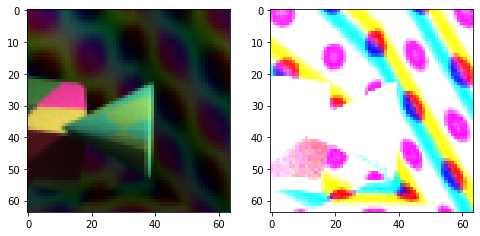

In [55]:
fig, ax = plt.subplots(1,2, figsize = (8, 8))
ax[0].imshow(img_noisy/img_noisy.max())
ax[1].imshow(np.clip(img_noisy * 5, 0, 1))
plt.show()

In [56]:
# plt.imshow(img_noisy[:16]/img_noisy[:16].max())
# plt.show()
# plt.imshow(img_noisy[-32:-16]/img_noisy[-32:-16].max())
# plt.show()

In [57]:
cam = LDRCamera()
sensor_noisy, sensor_noisy_float, bayer_noisy, bayer_noisy_float = cam.develop(img)

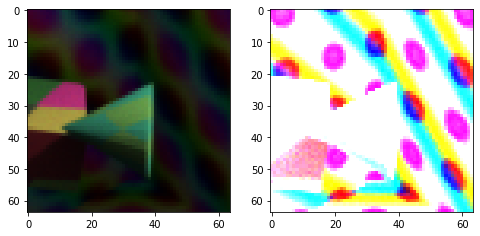

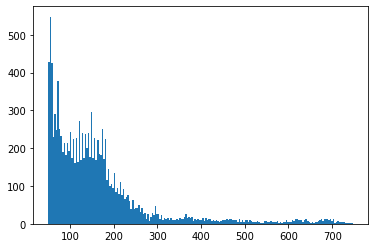

In [58]:
fig, ax = plt.subplots(1,2, figsize = (8, 8))
ax[0].imshow(sensor_noisy_float)
ax[1].imshow(np.clip(sensor_noisy_float * 30, 0, 1))
plt.show()
plt.hist(sensor_noisy.flatten(), bins=200)
plt.show()

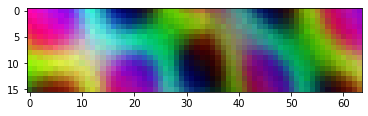

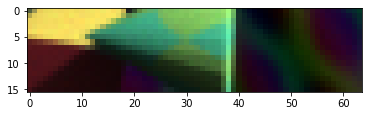

In [59]:
plt.imshow(sensor_noisy_float[:16]/sensor_noisy_float[:16].max())
plt.show()
plt.imshow(sensor_noisy_float[-32:-16]/sensor_noisy_float[-32:-16].max())
plt.show()

#### mosaic output

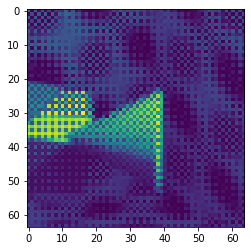

In [60]:
plt.imshow(bayer_noisy_float)
plt.show()

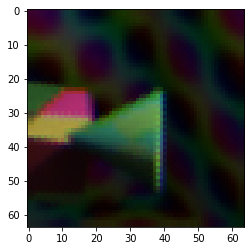

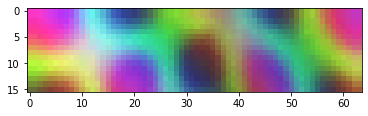

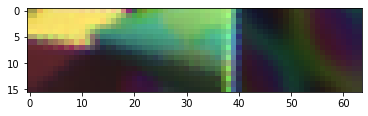

In [61]:
rgb_noisy = cv2.cvtColor(bayer_noisy, cv2.COLOR_BAYER_BG2RGB)
plt.imshow((rgb_noisy - 50).astype(np.float)/(1024.0 - 50.0))
plt.show()
plt.imshow(rgb_noisy[:16]/rgb_noisy[:16].max())
plt.show()
plt.imshow(rgb_noisy[-32:-16]/rgb_noisy[-32:-16].max())
plt.show()

also can be treated as demosaicing data.

### demo: a training sample

#### inputs

In [63]:
expo = 1.0/60.0
time_unit = 1.0/240.0
curr_timestamp = 100

prev_hdr = cv2.imread("Image/Image{:04d}.exr".format(curr_timestamp - 1),cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)[:, :, ::-1]
curr_hdr = []
for i in range(int(expo/time_unit)):
    img = cv2.imread("Image/Image{:04d}.exr".format(curr_timestamp + i),cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)[:, :, ::-1]
    curr_hdr.append(img)
curr_hdr = np.stack(curr_hdr).sum(axis = 0)

In [64]:
cam = LDRCamera()
sensor_noisy, sensor_noisy_float, bayer_noisy, bayer_noisy_float = cam.develop(curr_hdr)

In [65]:
sensor_noisy_norm = (sensor_noisy-cam.black_level).astype(np.float)/cam.amplitude/(expo/time_unit)

#### ground truth

In [66]:
curr_hdr = cv2.imread("Image/Image{:04d}.exr".format(curr_timestamp),cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)[:, :, ::-1]

#### visualization

 --- curr measure ------- prev est ------- curr label --- 


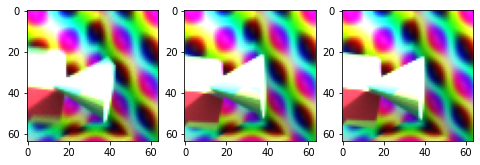

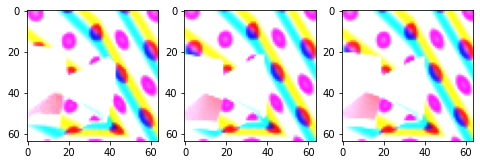

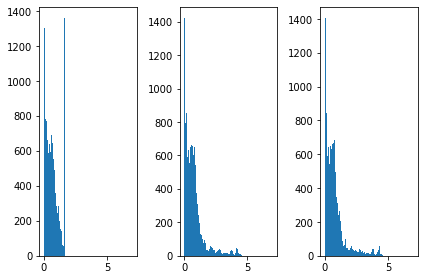

In [67]:
print(" --- curr measure ------- prev est ------- curr label --- ")
fig, ax = plt.subplots(1,3, figsize = (8, 8))
ax[0].imshow(np.clip(sensor_noisy_norm, 0, 1))
ax[1].imshow(np.clip(prev_hdr, 0, 1))
ax[2].imshow(np.clip(curr_hdr, 0, 1))
plt.show()
fig, ax = plt.subplots(1,3, figsize = (8, 8))
ax[0].imshow(np.clip(sensor_noisy_norm * 5, 0, 1))
ax[1].imshow(np.clip(prev_hdr * 5, 0, 1))
ax[2].imshow(np.clip(curr_hdr * 5, 0, 1))
plt.show()
fig, ax = plt.subplots(1,3)
ax[0].hist(sensor_noisy_norm.flatten(), bins = 100, range = (0, 7))
ax[1].hist(prev_hdr.flatten(), bins = 100, range = (0, 7))
ax[2].hist(curr_hdr.flatten(), bins = 100, range = (0, 7))
fig.tight_layout()
plt.show()

## Towards more realistic training samples
Till now scenes made by Blender are constructed by simple shapes with random textures, which does not fully explore the complexity of natural scenes.

By inspecting multiple patches from HDR images, I found details in a natural scene block:
* illumination changes √
* textures √
* uneven surface
* irregular geometry (faces, body parts, ...)
* transparent/reflective/... material

### thought A: 
Learn natural scenes representation through an autoencoder. When generate training data, Blender is applied to generate encoded patterns, and the decoder from autoencoder is applied to generate the scene.

*Comments: may be applicable to generate random scenes, but hard to simulate motions within the scene while keeping the contents unaltered. Also bit depth of synthetic scenes are questionable if the network is trained on 8bit image files. The byproducts like depth map and motion field are lost through the network, no matter what network structure is (e.g., 2d/3d).*


### thought B: 
use Blender to generate final ground truth with more details.

*Comments: Uneven surfaces*

## Reference code from [link](http://www.tobias-weis.de/groundtruth-data-for-computer-vision-with-blender/)

In [ ]:
import array
import OpenEXR
import Imath
import numpy as np
import cv2

def exr2flow(exr, w,h):
  file = OpenEXR.InputFile(exr)

  # Compute the size
  dw = file.header()['dataWindow']
  sz = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

  FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
  (R,G,B) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in ("R", "G", "B") ]

  img = np.zeros((h,w,3), np.float64)
  img[:,:,0] = np.array(R).reshape(img.shape[0],-1)
  img[:,:,1] = -np.array(G).reshape(img.shape[0],-1)

  return img

vector_from_openexr = exr2flow('Vector/Image0002.exr',64, 64)

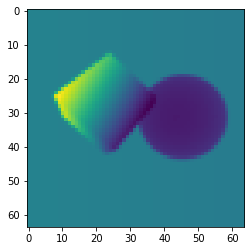

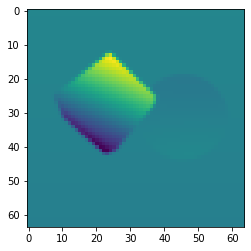

In [ ]:
plt.imshow(vector_from_openexr[:, :, 0]/vector_from_openexr.max())
plt.show()
plt.imshow(vector_from_openexr[:, :, 1]/vector_from_openexr.max())
plt.show()

In [ ]:
! pip install openexr

  Created wheel for openexr: filename=OpenEXR-1.3.2-cp37-cp37m-linux_x86_64.whl size=189342 sha256=7d7b7902eb0c5f068ca5a2ad67bdf2ec77f5e40bacefa466d22d05303469d8b9
  Stored in directory: /root/.cache/pip/wheels/41/06/9f/c7dc838815b0e7dfc7d7dc19cc3d677edb47594d8489adc62a
Successfully built openexr


In [ ]:
import OpenEXR as exr
exrfile = exr.InputFile('Vector/Image0001.exr')

In [ ]:
list(exrfile.header()['channels'])

['B', 'G', 'R']

In [ ]:
import Imath